# Welcome to my kernel!

This is a small tutorial on various "Feature Selection & Label Encoding Techniques". Hope you find it useful.

Lets start with importing necessary libraries

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.callbacks import Callback, EarlyStopping
import re
from sklearn.impute import KNNImputer
from tensorflow.keras import layers
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import category_encoders as ce
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [118]:
# load the data
train_set = pd.read_csv("/kaggle/input/cat-in-the-dat-ii/train.csv")
test_set = pd.read_csv("/kaggle/input/cat-in-the-dat-ii/test.csv")


In [119]:
# check the training set
train_set.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


Given dataset contains Numeric as well as Categorical Variables.

Following kind of categorical variabels are present in the dataset:
1. Binary Variables - values like Male & Female
2. Ordinal Variables (low and high cardinality) - ordered values like "Good" "V Good" "Excellent"
3. Nominal Variables (low and high cardinality) - do not have any intrinsic order, values like blood groups "A" "B" etc


In [120]:
# column 전체를 수치형 변수와 문자형 변수로 분류하기 (추후 feature scaling을 수치형 변수에 대해 취해주기 위함)
cat_vars = []
num_vars = []
for col in train_set:
    if train_set[col].dtypes == 'O': # 문자형 (object) 타입의 변수이면 cat_vars 안에 넣어라
        cat_vars.append(col)
    else:
        num_vars.append(col)

# removing id and target from the list # id와 target은 feature scaling하지 않을 것이므로 제외
num_vars.remove("id")
num_vars.remove("target")

In [121]:
# lets further segregate categorical variables in ordinal, nominal,binary and date variables
bin_vars = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
ord_vars = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5'] 
nom_vars = ['nom_0','nom_1','nom_2','nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
dat_vars = ['day','month']

In [122]:
# lets save training and test set "id"s for future use
#train_set_id = train_set.id
import copy

test_set_id = copy.deepcopy(test_set['id'])

# save training set target 
train_set_target = train_set.target

# lets drop targe and ids
train_set.drop(["id","target"],1,inplace= True)
test_set.drop("id",1,inplace= True)

#데이터 전처리를 한꺼번에 수행하기 위해 train & test 합치
master=pd.concat((train_set,test_set)).reset_index(drop=True)
master.shape

(1000000, 23)

bin_0 have 17894 null values
bin_1 have 18003 null values
bin_2 have 17930 null values
bin_3 have 18014 null values
bin_4 have 18047 null values
nom_0 have 18252 null values
nom_1 have 18156 null values
nom_2 have 18035 null values
nom_3 have 18121 null values
nom_4 have 18035 null values
nom_5 have 17778 null values
nom_6 have 18131 null values
nom_7 have 18003 null values
nom_8 have 17755 null values
nom_9 have 18073 null values
ord_0 have 18288 null values
ord_1 have 18041 null values
ord_2 have 18075 null values
ord_3 have 17916 null values
ord_4 have 17930 null values
ord_5 have 17713 null values
day have 17952 null values
month have 17988 null values


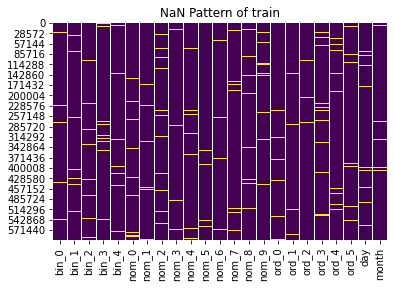

In [123]:
# Let's display the variables having null values
null_cols = []
for col in train_set.columns:
    if train_set[col].isnull().sum() > 0 :
        print('%s %s %d %s' %(col,"have",train_set[col].isnull().sum(),"null values"))    
        null_cols.append(col)

# 결측값 패턴 시각화
sns.heatmap(train_set.isnull(), cbar=False, cmap="viridis")
plt.title("NaN Pattern of train")
plt.show()

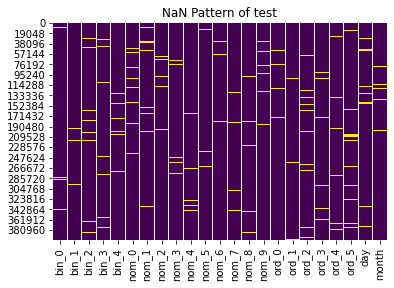

In [124]:
# 결측값 패턴 시각화
sns.heatmap(test_set.isnull(), cbar=False, cmap="viridis")
plt.title("NaN Pattern of test")
plt.show()

# Null Value Treatment

We will check the data only in the training set but will apply changes on the master dataset, why we are doing this?
because we dont want to look at the test data before feeding it into the model

In [125]:
# binary 피쳐들의 구성을 보자 (최빈값을 찾아서 결측치를 메꾸기 위함)
for col in bin_vars:
    print(col, ":\n",train_set[col].value_counts(),"\n")

bin_0 :
 0.0    528377
1.0     53729
Name: bin_0, dtype: int64 

bin_1 :
 0.0    474018
1.0    107979
Name: bin_1, dtype: int64 

bin_2 :
 0.0    419845
1.0    162225
Name: bin_2, dtype: int64 

bin_3 :
 F    366212
T    215774
Name: bin_3, dtype: int64 

bin_4 :
 N    312344
Y    269609
Name: bin_4, dtype: int64 



In [126]:
# bin_0~2는 최빈값이 0이므로 결측치를 0으로 채우자
master[['bin_0','bin_1','bin_2']] = master[['bin_0','bin_1','bin_2']].replace(np.nan, 0.0)

# missing values in bin_3 can be replaced with "F" (F가 최빈값)
master['bin_3'] = master['bin_3'].replace(np.nan, "F")

# missing values in bin_4 can be replaced with "N" (N이 최빈값)
master['bin_4'] = master['bin_4'].replace(np.nan, "N")

In [127]:
# lets take a look at the ordinal variables
for col in ord_vars:
    print(col, ":",train_set[col].value_counts(),'\n')

ord_0 : 1.0    227917
3.0    197798
2.0    155997
Name: ord_0, dtype: int64 

ord_1 : Novice         160597
Expert         139677
Contributor    109821
Grandmaster     95866
Master          75998
Name: ord_1, dtype: int64 

ord_2 : Freezing       142726
Warm           124239
Cold            97822
Boiling Hot     84790
Hot             67508
Lava Hot        64840
Name: ord_2, dtype: int64 

ord_3 : n    70982
a    65321
m    57980
c    56675
h    55744
o    45464
b    44795
e    38904
k    38718
i    34763
d    30634
f    29450
g     6180
j     3639
l     2835
Name: ord_3, dtype: int64 

ord_4 : N    39978
P    37890
Y    36657
A    36633
R    33045
U    32897
M    32504
X    32347
C    32112
H    31189
Q    30145
T    29723
O    25610
B    25212
E    21871
K    21676
I    19805
D    17284
F    16721
W     8268
Z     5790
S     4595
G     3404
V     3107
J     1950
L     1657
Name: ord_4, dtype: int64 

ord_5 : Fl    10562
DN     9527
Sz     8654
RV     5648
oJ     5596
      ...  
vw   

In [128]:
# 순서형 피처의 분포는 값이 골고루 분포되어 있으므로 결측치는 'missing'이라는 문자열로 대체
master[ord_vars] = master[ord_vars].replace(np.nan,"missing")


In [129]:
# 명목형 피처의 구성을 보자
for col in nom_vars:
    print(col, ":",train_set[col].value_counts(), '\n')

nom_0 : Red      323286
Blue     205861
Green     52601
Name: nom_0, dtype: int64 

nom_1 : Triangle     164190
Polygon      152563
Trapezoid    119438
Circle       104995
Square        26503
Star          14155
Name: nom_1, dtype: int64 

nom_2 : Hamster    164897
Axolotl    152319
Lion       119504
Dog        104825
Cat         26276
Snake       14144
Name: nom_2, dtype: int64 

nom_3 : India         164869
Costa Rica    151827
Russia        119840
Finland       104601
Canada         26425
China          14317
Name: nom_3, dtype: int64 

nom_4 : Theremin    308621
Bassoon     196639
Oboe         49996
Piano        26709
Name: nom_4, dtype: int64 

nom_5 : fc8fc7e56    977
360a16627    972
7917d446c    961
423976253    961
079b76328    960
            ... 
7335087fd      5
30019ce8a      3
b3ad70fcb      1
d6bb2181a      1
0385d0739      1
Name: nom_5, Length: 1220, dtype: int64 

nom_6 : ea8c5e181    805
9fa481341    798
2b94ada45    792
32e9bd1ff    788
b88220966    781
            

In [130]:
# "Red" is most frequent value for nom_0 variable, lets replace missing values with "Red"
master['nom_0'] = master['nom_0'].replace(np.nan,"Red")

# "Theremin" is most frequent value for nom_0 variable, lets replace missing values with "Theremin"
master['nom_4'] = master['nom_4'].replace(np.nan,"Theremin")

# 다른 명목형 피처는 뚜렷하게 많은 수의 값이 있진 않으므로 결측치는 'missing'이란 값으로 대체한다
master[['nom_1','nom_2','nom_3','nom_5','nom_6','nom_7','nom_8','nom_9']] = master[['nom_1','nom_2','nom_3','nom_5','nom_6','nom_7','nom_8','nom_9']].replace(np.nan,"missing")

In [131]:
# 날짜 피처의 구성을 보자
for col in dat_vars:
    print(col, ":",train_set[col].value_counts(), '\n')

day : 3.0    113835
5.0    110464
6.0     97432
7.0     86435
1.0     84724
2.0     65495
4.0     23663
Name: day, dtype: int64 

month : 8.0     79245
3.0     70160
5.0     68906
12.0    68340
6.0     60478
7.0     53480
1.0     52154
11.0    51165
2.0     40700
9.0     20620
4.0     14614
10.0     2150
Name: month, dtype: int64 



In [132]:
# 날짜피처는 두드러지게 많은 특정 값이 있진 않으므로 결측치는 0으로 대체하자 (리스트에 없는 값)
master[dat_vars] = master[dat_vars].replace(np.nan,0.0)

In [133]:
# lets confirm if there are any missing values leftr
master.isnull().sum()

bin_0    0
bin_1    0
bin_2    0
bin_3    0
bin_4    0
nom_0    0
nom_1    0
nom_2    0
nom_3    0
nom_4    0
nom_5    0
nom_6    0
nom_7    0
nom_8    0
nom_9    0
ord_0    0
ord_1    0
ord_2    0
ord_3    0
ord_4    0
ord_5    0
day      0
month    0
dtype: int64

No Null values left, good!

# Handling Categorical Variables
As stated above, we have different kind of categorical variabels present in the dataset. We would apply different kind of encoding techniques on them:

1. Binary Variables                     - will be replaced by 0 and 1
2. Ordinal Variables (low cardinality)  - will apply Label Encoding
3. Ordinal Variables (high cardinality) - will apply Label Encoding
4. Nominal Variables (low cardinality)  - will apply One Hot Encodihng
5. Nominal Variables (high cardinality) - will apply Hashing Encoding

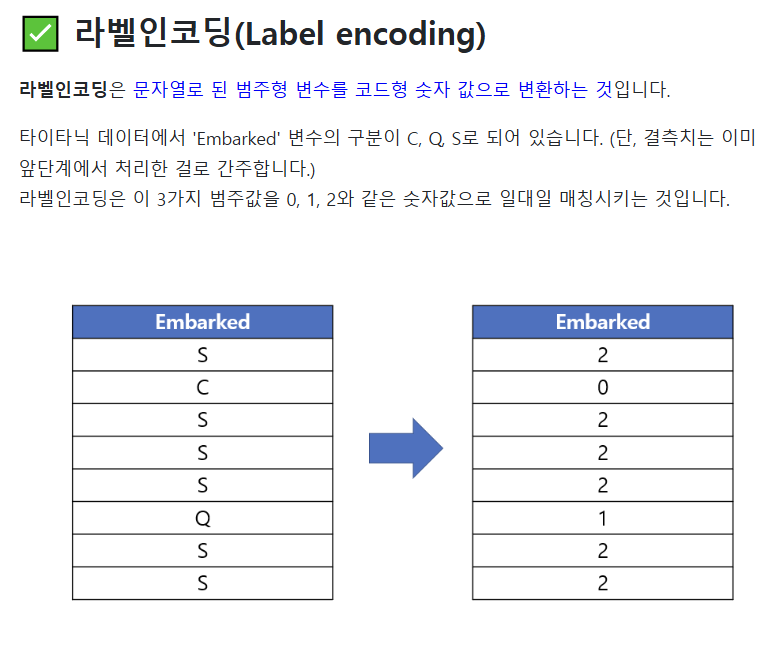

## 해쉬 인코딩이란? 
- 해시 함수를 활용해서 텍스트 데이터를 고정된 크기의 벡터를 변환하는 방법을 말합니다. 주로 대규모 텍스트 데이터를 인코딩할 때 사용됩니다.
출처: https://jaylala.tistory.com/entry/개념정리 [Innov_AI_te:티스토리]

In [134]:
# lets encode binary variables

master['bin_3'] = master['bin_3'].map({'F': 1, 'T': 0})

master['bin_4'] = master['bin_4'].map({'Y': 1, 'N': 0})

In [ ]:
# 순서형 피처에는 라벨인코딩을 적용하자
# 라벨 인코딩을 할 때 기본적으로 LabelEncoder는 알파벳 순서대로 데이터를 인코딩
lbl = preprocessing.LabelEncoder()
for col in ord_vars:
    master[col] = lbl.fit_transform(master[col].astype(str).values)

In [136]:
# 명목형 피처를 저차원과 고차원으로 나누자
low_card_nom_vars = []
high_card_nom_vars = []

for col in nom_vars:
    if train_set[col].nunique()>10:
        high_card_nom_vars.append(col)
    else:
        low_card_nom_vars.append(col)

In [137]:
# lets take a quick look at the lists created
low_card_nom_vars, high_card_nom_vars

(['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],
 ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'])

In [138]:
# low_card_nom_vars 리스트에 포함된 저차원 명목형 변수들을 원-핫 인코딩
dummies = pd.get_dummies(master[low_card_nom_vars], drop_first=True)

# 원본 데이터프레임(master)에 더미 변수들(인코딩 결과)을 추가
master = pd.concat([master, dummies], axis=1)

# 더미 변수로 대체된 원래 명목형 변수를 master에서 삭제
master.drop(low_card_nom_vars,1,inplace = True)

In [139]:
# 고차원 명목형 변수들은 해쉬 인코딩 하자
ce_hash = ce.HashingEncoder(cols = high_card_nom_vars)
master = ce_hash.fit_transform(master)

In [140]:
master.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'ord_0', 'ord_1', 'ord_2',
       'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'nom_0_Green', 'nom_0_Red',
       'nom_1_Polygon', 'nom_1_Square', 'nom_1_Star', 'nom_1_Trapezoid',
       'nom_1_Triangle', 'nom_1_missing', 'nom_2_Cat', 'nom_2_Dog',
       'nom_2_Hamster', 'nom_2_Lion', 'nom_2_Snake', 'nom_2_missing',
       'nom_3_China', 'nom_3_Costa Rica', 'nom_3_Finland', 'nom_3_India',
       'nom_3_Russia', 'nom_3_missing', 'nom_4_Oboe', 'nom_4_Piano',
       'nom_4_Theremin'],
      dtype='object')

In [141]:
master.shape


(1000000, 44)

In [142]:
# 데이터 전처리는 끝났으니 train / test 다시 분리

train_set = master[:train_set.shape[0]]

test_set = master[train_set.shape[0]:]

# lets confirm the shape of train and test datasets
train_set.shape, test_set.shape

((600000, 44), (400000, 44))

# Feature Scaling

In [143]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 학습 데이터에 대해 스케일러를 맞추고 변환 적용
train_set[num_vars] = scaler.fit_transform(train_set[num_vars])

# 테스트 데이터는 같은 스케일러를 사용하여 변환만 적용
test_set[num_vars] = scaler.transform(test_set[num_vars])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [144]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train_set,train_set_target, train_size=0.7,test_size=0.3,random_state=100)

In [145]:
# lets create a dataframe to save model's performance
model_df = pd.DataFrame(columns = ["model_name","training roc_auc","test_roc_auc"])

In [146]:
# Confusion matrix function
def cm(pred,true):
    confusion = metrics.confusion_matrix(pred, true)
    print(confusion)
    score = round(metrics.roc_auc_score(pred,true),2)
    print("roc_auc score:",score)
    return(score)


In [147]:
col = X_train.columns

# Logistic Regression - Default

In [148]:
X_train = X_train[col]

X_test = X_test[col]

In [149]:
logModel = LogisticRegression(class_weight = "balanced",solver = "saga", max_iter=500)
res = logModel.fit(X_train,y_train)

In [150]:
# make predictions
y_train_pred_prob = res.predict_proba(X_train)
y_train_pred = res.predict(X_train)

y_test_pred_prob = res.predict_proba(X_test)
y_test_pred = res.predict(X_test)

In [151]:
print("training scores:")
train_score = cm(y_train_pred,y_train)

print("\ntest scores:\n")
test_score = cm(y_test_pred,y_test)

model_df.loc[0] = ["LogisticReg-Default",train_score,test_score]

training scores:
[[224599  25946]
 [116679  52776]]
roc_auc score: 0.6

test scores:

[[96589 11087]
 [49810 22514]]
roc_auc score: 0.6


In [154]:
test_pred = res.predict(test_set)

sub = pd.DataFrame()
sub['Id'] = test_set_id
sub['target'] = test_pred
sub.to_csv('submission_ann.csv',index=False)

In [155]:
print(len(test_set_id))
print(len(test_pred))

400000
400000


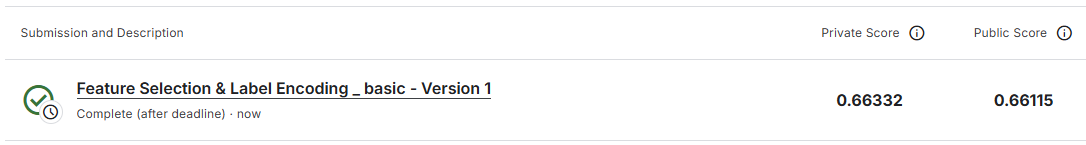
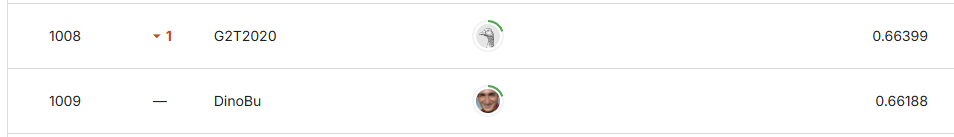